Ce programme décrit les étapes établies pour l'extraction de relations entre les différents claims postés dans chaque rubrique sur le site Fullfact. Nous avons utilisé pour cela le classifier Kmeans (classification non-supervisée) car nous n'avons pas les labels de classes pour lesquels nous voulons regrouper les claims. Autrement dit, le but est d'essayer de trouver les relations entre les claims postés dans chaque rubrique (si elles existent).





In [1]:
#Les imports necessaires au programme.
import sys
import import_ipynb
import pandas as pd
import Claim as claim_obj
from nltk import word_tokenize , sent_tokenize 
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import TraitementConclusion
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import numpy as np
from sklearn.decomposition import PCA
import pickle
from yellowbrick.cluster.elbow import kelbow_visualizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from yellowbrick.cluster import KElbowVisualizer

importing Jupyter notebook from Claim.ipynb
importing Jupyter notebook from TraitementConclusion.ipynb


/home/nihedb/env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


les articles - et donc les claims - du site sont regroupés en un bon nombres de rubriques :law, economy,europe, health, crime, immigration, educationetonline.
Nous avons donc lancé notre programme extracteur et avons récupéré un ensemble de  claims pour chaque rubrique.
Nous avons stocké ces claims dans des fichiers pour pouvoir les manipuler et faire nos expérimentations sans avoir à lancer l'extracteur à chaque fois.


* Remarque 1 : Lors de l'extraction, nous récupérons les claims ainsi que leurs titres car nous avons remarqué que le titre peut être souvent très indicateur quant à la relation qui existe entre les claims ( il contient des mots clés ou une reformulation du claim avec des mots existants dans les autres claims).

* Remarque 2 : Ce notebook montre uniquement les expérimentations sur les quatre rubriques : Economy, Europe, Health et Online.


In [12]:
ponctuation=[".",",","!",";","?", "'", "â€˜", "â€™"]
mots=["people", "new", "list", "years", "days"]
stop_words = stopwords.words('english')
pos_tag=["JJ", "JJR", "JJS", "RBR", "RBS", "NN", "NNS"]

rubriques={}

with open("rubriques", 'rb') as fichier:
    mon_depickler = pickle.Unpickler(fichier)
    rubriques=mon_depickler.load()
fichier.close()


Une fois tous les claims recupérés, nous procédons au nettoyage du texte. Ainsi, nous commençons par dissocier les contractions,enlever les stop words, la ponctuation et les caractères spéciaux. Ensuite, nous appliquons la lemmatization sur les mots pour les transformer sous une forme canonique.
Enfin, nous appliquons un analyseur morphosyntaxique sur notre texte afin de ne garder que les noms et les adjectifs.

In [3]:
#Fonction qui prend en paramètre un claim et qui se charge de traiter les contractions, mettre les caractères en minuscule et eliminer les stopwords, 
#la ponctuation et les mots qui se repêtent beaucoup. Elle se charge également de lemmatiser les termes et d'appliquer un analyseur morpho-syntaxique 
#sur eux pour déterminer leur genre. 
def pretraitement_Texte(post):
    tempo=[]
    resultat=[]
    pos= TraitementConclusion.nettoyage(post)
    pos=TraitementConclusion.lemmatization(pos)
    result= TraitementConclusion.eliminationStopWords(pos)
    result= [word for word in result if word not in ponctuation and word not in mots]  
    for r in result:
        if ("-" in r):
            k=r.replace("-","")
            result.remove(r)
            if k not in result:
                result.append(k)
    #Pour vérifier que le mot existe et n'est pas une chaine de caractères vide            
    clean_sample_list = [word for word in result if word]
    tempo=nltk.pos_tag(clean_sample_list)
    i=0
    while i < len(tempo):
        if (tempo[i][1] in pos_tag):
            if tempo[i][0] not in resultat:
                resultat.append(tempo[i][0])
        i+=1       
    phrase= " ".join(resultat)  
    return phrase


#Fonction qui parcourt les claims et qui extrait le titre et le texte de chaque claim et les concatène. Elle appelle ensuite la fonction de prétraitement 
#sur le résultat de la concaténation.  
def extractionTexte(claims, RP=False):
    posts=[]

    for v in claims:
        if RP:
            post= v[1] + " " + v[2]
        else:
            post= v.getTitle() + " " + v.getClaim()

        post= post.replace(".", "")
        ph=pretraitement_Texte(post)
        posts.append(ph)
     
    return posts
 


Ensuite, nous avons appliqué la méthode "Elbow" qui a pour but de trouver le bon k pour fragmenter nos données. Cette méthode consiste à lancer K-Means avec différentes valeurs de K et de calculer la variance des différents clusters. La bonne valeur de k se trouve dans le point du graphe qui représente le coude (d'où le nom de "elbow").

In [4]:
def getElbow(corpus):
    vectorizer = CountVectorizer()
    res= vectorizer.fit_transform(corpus)      
    visualizer=KElbowVisualizer(KMeans(), k=(2,10), timings=False)
    visualizer.fit(res)        # Fit the data to the visualizer
    visualizer.show()
    



Voici donc ce que cela donne avec la rubrique Health:

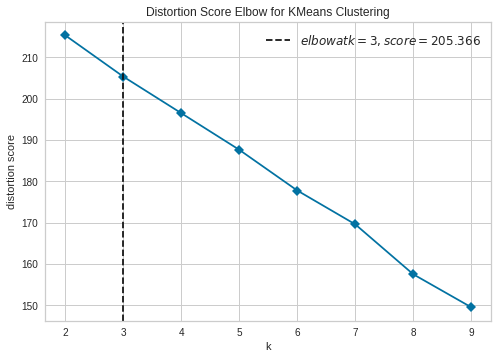

In [6]:
retour= extractionTexte(rubriques["health"])
getElbow(retour)

Et sur la rubrique Economy :

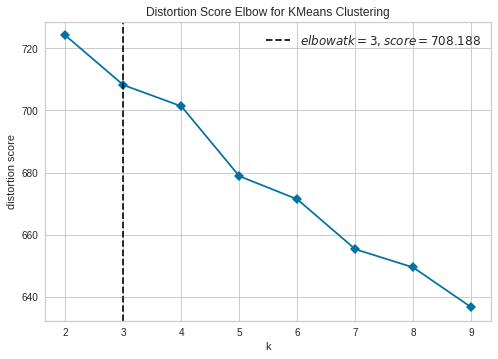

In [57]:
retour= extractionTexte(rubriques["economy"])
getElbow(retour)

Rubrique Europe :

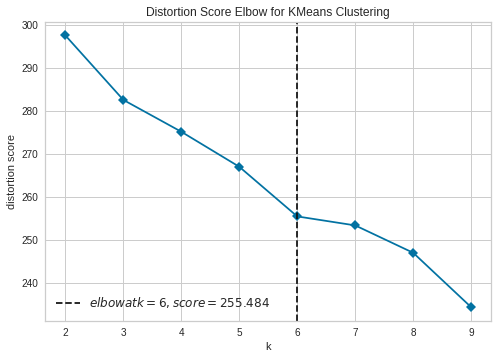

In [8]:
retour= extractionTexte(rubriques["europe"])
getElbow(retour)

Rubrique online:

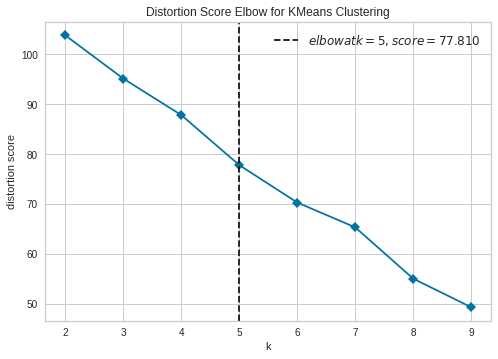

In [9]:
retour= extractionTexte(rubriques["online"])
getElbow(retour)

L'étape suivante consiste  à :
  1. construire une matrice à partir de nos claims prétraités et à appliquer kmeans avec le bon k pour chaque      jeu de données (rubrique). 
  2. Afficher notre matrice de mots et le résultat de kmeans sur un plan 2D pour visualiser les clusters construits ainsi que leurs centroids.
  3. Afficher les top 5 mots de chaque cluster.
  
Voici donc le code qui permet de faire cela. à noter que la matrice a été construite à partir du score TF-IDF des mots des claims.


In [10]:
def classification_kmeans(posts, true_k, rubrique):
    
    vectorizer = TfidfVectorizer()
 

    df = pd.DataFrame(
    data=vectorizer.fit_transform(posts).toarray(),
    columns=vectorizer.get_feature_names()
    )
    res= vectorizer.fit_transform(posts)
  

    model = KMeans(n_clusters=true_k)
    model.fit(res)
    
    kmeans_indices = model.fit_predict(res)

    
    #affichage des points avec PCA
    pca = PCA(n_components=2).fit(res.todense())
    data2D = pca.transform(res.todense())
    centers = np.array(pca.transform(model.cluster_centers_))
    plt.title('Visualisation du résultat de Kmeans et de la distribution des données ( '+rubrique+' )')
    plt.scatter(data2D[:,0], data2D[:,1], c=kmeans_indices , cmap='rainbow')


    plt.scatter(centers[:,0], centers[:,1], marker="x", color='black')
    plt.figure(figsize=(16,8))
  
    plt.show()


   #affichage des top mots clés par cluster
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
  

    print("Top terms per cluster ( " +rubrique+" )")
    topMC=[]
    for i in range(true_k):
        topMC.append([])
        for ind in order_centroids[i, :5]:
            print(terms[ind])
            topMC[i].append(terms[ind])
        print("-----end cluster-----")
    #print (topMC)

    return topMC, kmeans_indices
  

#Fonction qui prend comme paramètres les résultats de K-means et qui retourne les mots clés reliant les claims d'une certaine rubrique.
def recuperationElementsPredits(topMC, indices, true_k, claims):

    
    cc=[]
    c={}
    for k in range(true_k):
        c[k]=[]
        r=0
        while r < len(indices) :
            if indices[r]==k:
                c[indices[r]].append(claims[r])
            r+=1
        c[k].append(topMC[k])
   
    for valeur in c.values(): 
        i=0
        while i < len(valeur)-1:
            valeur[i].setRelated_posts("ClaimsSimilaires", [w.getUrl() for w in valeur if w!=valeur[i] and w != valeur[len(valeur) -1]])
            valeur[i].setKeyWordsRP("ClaimsSimilaires",valeur[len(valeur)-1])
            cc.append(valeur[i].getDict())
            i+=1
    
 
    return cc


#Fonction qui prend comme paramètres les résultats de K-means et qui retourne les mots clés reliant les claims de la rubrique Related Posts.
def recuperationRelatedPosts(relp, topMC, indices, true_k):
    i=0
    groupe=[]
        
    for i in range(true_k):
        r=0
        while r < len(indices) :
            if indices[r]==i:
                groupe.append(relp[r][0])
            r+=1
        groupe.append(topMC[i])
    return groupe




#Fonction qui fait appel à l'ensemble des fonctions précédentes  
def relationClaims(true_k, rubrique, claims, RP=False):
    if RP:
        retour= extractionTexte(claims, RP=True)
        topMC, indices=classification_kmeans(retour, true_k, rubrique)
        results=recuperationRelatedPosts(claims, topMC, indices, true_k)  

    else:    
        retour= extractionTexte(claims)
        topMC, indices=classification_kmeans(retour, true_k, rubrique)
        results=recuperationElementsPredits(topMC, indices, true_k, claims)
   
    return results





Voici donc le résultat de la classification sur l'ensemble des rubriques:

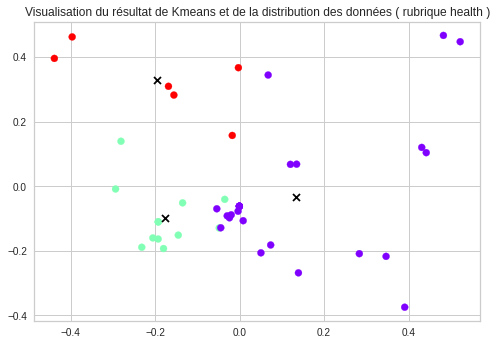

<Figure size 1152x576 with 0 Axes>

Top terms per cluster ( rubrique health )
year
rise
gp
covid19
appointments
-----end cluster-----
nhs
nurse
service
10
extra
-----end cluster-----
health
mental
tourism
cost
number
-----end cluster-----


''

In [29]:
relationClaims(3, "rubrique health", rubriques["health"])
;

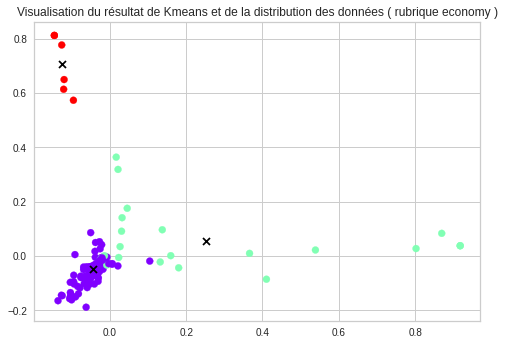

<Figure size 1152x576 with 0 Axes>

Top terms per cluster ( rubrique economy )
uk
government
tax
poverty
conservatives
-----end cluster-----
pay
credit
work
universal
gap
-----end cluster-----
unemployment
lowest
rise
level
low
-----end cluster-----


''

In [50]:
relationClaims(3, "rubrique economy", rubriques["economy"])
;

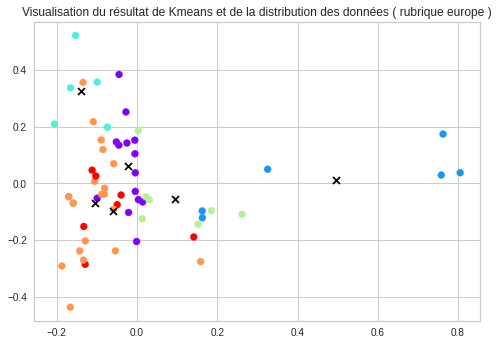

<Figure size 1152x576 with 0 Axes>

Top terms per cluster ( rubrique europe )
plan
uk
army
union
deal
-----end cluster-----
brexit
extension
month
cost
research
-----end cluster-----
trade
postbrexit
agreements
eu
deal
-----end cluster-----
vote
theresa
brexit
remain
millions
-----end cluster-----
eu
referendum
uk
quit
poll
-----end cluster-----
mean
asylum
countries
seekers
last
-----end cluster-----


''

In [58]:
relationClaims(6, "rubrique europe",rubriques["europe"])
;

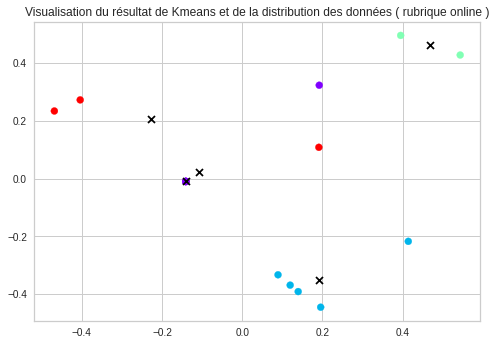

<Figure size 1152x576 with 0 Axes>

Top terms per cluster ( rubrique online )
park
wales
heart
attack
cough
-----end cluster-----
uk
shamima
begum
survival
rate
-----end cluster-----
officer
police
world
die
covid19
-----end cluster-----
communication
albert
decisions
mean
make
-----end cluster-----
coronavirus
use
photo
force
different
-----end cluster-----


''

In [59]:
relationClaims(5, "rubrique online", rubriques["online"])
;


Analyse du résultat obtenu :

Sur la rubrique health et economy, l'algorithme à un meilleur résultat (regroupement des points proches dans le même cluster et espacement des clusters entre eux) que sur les rubriques europe ou online. Nous nous attendions en partie à ce résutat car lors de l'analyse manuelle du site nous avons remarqué que les rubriques online et europe ne traitent pas des thématiques bien définies (online peut contenir des claims qui ont des thématiques qui concernent la santé ou l'économie par exemple) donc le regroupement est plus difficile à réaliser.
